In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import time
import re
import pickle
from string import punctuation

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_colwidth', -1)




<ipython-input-1-2cef7bd5f5b8>:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
df = pd.read_json('../../../data/data.json', lines=True)

df.head(5)

,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [3]:
df.shape

(200853, 6)

In [4]:
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [5]:


groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

groupper( grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

groupper( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')



In [6]:


print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()



We have a total of 12 categories now


LIFESTYLE AND WELLNESS          40619
POLITICS                        32739
SPORTS AND ENTERTAINMENT        30296
TRAVEL-TOURISM & ART-CULTURE    20578
EMPOWERED VOICES                15461
PARENTING AND EDUCATION         14780
MISC                            12448
GENERAL                         9663 
WORLDNEWS                       8420 
BUSINESS-MONEY                  7644 
SCIENCE AND TECH                4260 
ENVIRONMENT                     3945 
Name: category, dtype: int64

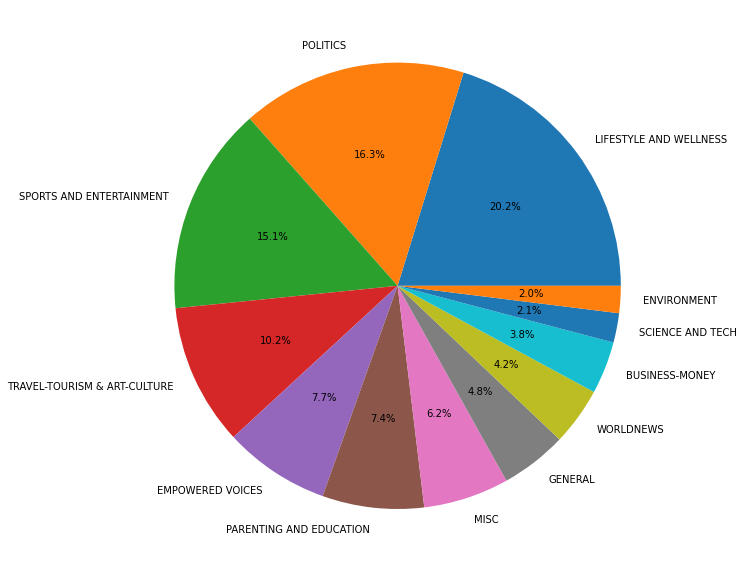

In [8]:
fig = plt.figure(figsize=(10,20))
plt.pie(df['category'].value_counts().values, 
        labels=df['category'].value_counts().index,
        autopct='%1.1f%%');
plt.savefig('..\..\..\data\categories2.jpg', bbox_inches="tight")

In [26]:
df

,category,headline,authors,link,short_description,date
0,GENERAL,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,SPORTS AND ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,SPORTS AND ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,SPORTS AND ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,SPORTS AND ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,SCIENCE AND TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS AND ENTERTAINMENT,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS AND ENTERTAINMENT,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS AND ENTERTAINMENT,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [27]:
df.drop(['authors', 'link', 'date'], axis = 1, inplace = True) 

In [38]:
df.shape

(200853, 2)

In [39]:
df2.shape

(200853, 2)

In [28]:
df['text'] = df['headline'] + df['short_description']
df

,category,headline,short_description,text
0,GENERAL,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...
1,SPORTS AND ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...
2,SPORTS AND ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...
3,SPORTS AND ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,SPORTS AND ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...,...,...
200848,SCIENCE AND TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS AND ENTERTAINMENT,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS AND ENTERTAINMENT,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...","Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS AND ENTERTAINMENT,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [29]:
df.drop(['headline', 'short_description'], axis = 1, inplace = True)
df

,category,text
0,GENERAL,There Were 2 Mass Shootings In Texas Last Week...
1,SPORTS AND ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,SPORTS AND ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,SPORTS AND ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,SPORTS AND ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
200848,SCIENCE AND TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,SPORTS AND ENTERTAINMENT,Maria Sharapova Stunned By Victoria Azarenka I...
200850,SPORTS AND ENTERTAINMENT,"Giants Over Patriots, Jets Over Colts Among M..."
200851,SPORTS AND ENTERTAINMENT,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [30]:


def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



In [1]:
REMOVE_SPECIAL_CHARACTER = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # part 1
    text = text.lower() # lowering text
    text = REMOVE_SPECIAL_CHARACTER.sub('', text) # replace REPLACE_BY_SPACE symbols by space in text
    text = BAD_SYMBOLS.sub('', text) # delete symbols which are in BAD_SYMBOLS from text
    
    # part 2
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in STOPWORDS:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    text = " ".join(clean_text)
    
    return text

NameError: name 're' is not defined

In [32]:
df['text'] = df['text'].apply(clean_text)

In [33]:
df.to_csv('cleaned_news.csv', index=False, columns=['category', 'text'])

In [37]:

df2.isna().sum()

category     0
text        12
dtype: int64

In [5]:
df2 = pd.read_csv('cleaned_news.csv')
df2


,category,text
0,GENERAL,2 mass shooting texas last week 1 tvshe left h...
1,SPORTS AND ENTERTAINMENT,smith join diplo nicky jam 2018 world cup offi...
2,SPORTS AND ENTERTAINMENT,hugh grant marries first time age 57the actor ...
3,SPORTS AND ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...
4,SPORTS AND ENTERTAINMENT,julianna margulies us donald trump poop bag pi...
...,...,...
200848,SCIENCE AND TECH,rim ceo thorsten heins significant plan blackb...
200849,SPORTS AND ENTERTAINMENT,maria sharapova stun victoria azarenka austral...
200850,SPORTS AND ENTERTAINMENT,giant patriot jet colt among improbable super ...
200851,SPORTS AND ENTERTAINMENT,aldon smith arrest 49ers linebacker bust duico...


In [6]:
df2.isna().sum()

category     0
text        12
dtype: int64

In [7]:
df2.dropna(subset=['text'], inplace=True)

In [8]:
df2.shape

(200841, 2)

In [9]:
X= df2.text
y= df2.category

X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42)

In [7]:
from imblearn.pipeline import make_pipeline
# Creating Models
models = [('Logistic Regression', LogisticRegression(max_iter=1000)),('Random Forest', RandomForestClassifier()),
          ('Linear SVC', LinearSVC()), ('Multinomial NaiveBayes', MultinomialNB()), ('SGD Classifier', SGDClassifier())]

names = []
results = []
model = []
for name, clf in models:
    pipe = make_pipeline(CountVectorizer(max_features=10000, ngram_range=(1, 2)),
                        TfidfTransformer(),
                        SMOTE(),
                        clf )
    # pipe = Pipeline([('vect', CountVectorizer(max_features=30000, ngram_range=(1, 2))),
    #                 ('tfidf', TfidfTransformer()),
    #                 (name, clf),
    #                 ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    
    names.append(name)
    results.append(accuracy)
    model.append(pipe)
    
    msg = "%s: %f" % (name, accuracy)
    print(msg)

Logistic Regression: 0.641612
Random Forest: 0.593037
Linear SVC: 0.622792


MemoryError: Unable to allocate 1.00 GiB for an array with shape (7279, 18438) and data type float64

In [8]:
# Logistic Regression
filename = 'logreg_model_smote2.sav'
pickle.dump(model[0], open(filename, 'wb'))

# Linear SVC
#filename = 'lin_svc_model.sav'
#pickle.dump(model[2], open(filename, 'wb'))

In [3]:
lr_model = pickle.load(open('logreg_model_smote2.sav', 'rb'))

In [5]:
text_1 = "Swiss government rejects call to ban fossil fuels from 2050"
text_2 = "Tunis hit record 49C in heat wave on Tuesday"
print(lr_model.predict([text_1, text_2]))

['SCIENCE AND TECH' 'ENVIRONMENT']


In [17]:
from sklearn.metrics import confusion_matrix

#y_pred = prediction(X_test)
#print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(df2['category'])


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')



TypeError: confusion_matrix() missing 1 required positional argument: 'y_pred'